<a href="https://colab.research.google.com/github/rodrigosarloaf/projeto_DL_23_1/blob/main/modelo_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Pacotes
import os
import time
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy import stats
import pickle
from PIL import Image, ImageDraw, ImageFont
#
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.backend import expand_dims, repeat_elements
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import ConvLSTM2D, ConvLSTM3D, Bidirectional, Input, Permute, Reshape, TimeDistributed, Lambda, Conv2D, Conv3D, Dense, Dropout, Normalization, BatchNormalization, add, SeparableConv2D, Conv2DTranspose
from tensorflow.keras import layers

In [2]:
from google.colab import drive
# Conectando ao drive
drive.mount('/content/drive', force_remount=True)
root_path = '/content/drive/My Drive/projeto_DL/'
os.chdir(root_path)

Mounted at /content/drive


In [3]:
def retorna_pesos(y):
  cte = 0.8 # 0 desativa
  w_ = np.zeros(y.shape, np.float32)
  w_[y == 0] = ((1/1586)*(1-cte))
  w_[y == 1] = (1-((1/1586)*(1-cte)))
  w_[y == 2] = 0.00
  return w_

In [4]:
# DataGenerator de https://github.com/mauriciodev/tec_forecast/blob/main/examples/tec_forecast_tf2_lab.ipynb
# split_sequence alterada para levar em conta que estamos trabalhando com patches na linha 71
# e também o self.list_IDs da linha 9
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, x, batch_size, nstepsin=4, nstepsout=1, shuffle=True,training=True, sample_rate=12, val_split=0, validation=False, random_state=23, test_set = 0):
        'Initialization'
        super().__init__()
        self.list_IDs=range(0,len(x)-(nstepsout-1+nstepsin)*100,sample_rate) #store the index to allow shuffling
        if val_split>0:
            datasplit=train_test_split(self.list_IDs,random_state=random_state, test_size=val_split)
            if validation==False: #training generator
                self.list_IDs=datasplit[0]
            else:
                self.list_IDs=datasplit[1]

        # Procedimento para reduzir o tamanho da amostra
        if test_set == 0:
          id_keep = []
          for current_id in self.list_IDs:
            l_test = x[current_id:current_id+(2*100):100]
            if np.any(l_test[1] == 1):
              id_keep.append(current_id)
          self.list_IDs = id_keep

        self.x=x
        self.nstepsin=nstepsin
        self.nstepsout=nstepsout
        self.batch_size=batch_size
        self.dim=x[0].shape
        self.shuffle=shuffle
        self.training=training
        self.on_epoch_end()

    def count(self):
        'Returns the number of samples'
        return len(self.list_IDs)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        if self.training:
            return X, y, retorna_pesos(y)
        else:
            return X

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = []
        Y = []
        # Generate data
        for ID in list_IDs_temp:
            x,y=self.split_sequence(ID)
            X.append(x)
            Y.append(y) # <- alteração aqui
        return np.array(X), np.array(Y).astype(np.int32)

    def split_sequence(self, i):
        # find the end of this pattern
        end_ix = i + self.nstepsin*100
        # check if we are beyond the sequence
        #if (end_ix + (self.nstepsout)*100) > len(self.x):
        #    return None,None
        # gather input and output parts of the pattern
        seq_x, seq_y = self.x[i:end_ix:100], self.x[end_ix:(end_ix+(self.nstepsout*100)):100]
        return seq_x,seq_y

    def asArray(self):
        return self.__data_generation(self.list_IDs)

In [5]:
# Abrindo dados
with open("/content/drive/My Drive/projeto_DL/dataset_tratado/train_npy.pkl", 'rb') as handle:
  train_npy = pickle.load(handle)

with open("/content/drive/My Drive/projeto_DL/dataset_tratado/test_npy.pkl", 'rb') as handle:
  test_npy = pickle.load(handle)

print(len(train_npy))
print(len(test_npy))

20800
5200


In [6]:
def modelo_01(inputShape):
  in_im = Input(shape = inputShape)
  x = in_im
  # Parte "temporal"
  x = BatchNormalization()(x)
  x = ConvLSTM2D(filters=12, kernel_size=(9,9), padding="same")(x)
  x = BatchNormalization()(x)
  # Parte U-net - https://keras.io/examples/vision/oxford_pets_image_segmentation/
  previous_block_activation = x  # Set aside residual
  temporal = x
  # Blocks 1, 2, 3 are identical apart from the feature depth.
  for filters in [12, 24, 32]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
        previous_block_activation
        )
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  ### [Second half of the network: upsampling inputs] ###
  for filters in [32, 24, 12]:
    x = layers.Activation("relu")(x)
    x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)

    # Project residual
    residual = layers.UpSampling2D(2)(previous_block_activation)
    residual = layers.Conv2D(filters, 1, padding="same")(residual)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  x = layers.add([x, temporal])

  x = Lambda(lambda x: expand_dims(x, axis=1))(x)

  x = layers.BatchNormalization()(x)

  # Add a per-pixel classification layer
  outputs = layers.Conv2D(filters=3, kernel_size=(3,3), activation="softmax", padding="same")(x)
  return Model(in_im, outputs, name=sys._getframe().f_code.co_name)


In [7]:
nstepsin=15
nstepsout=1
time_stride=1
batch_size=16
random_seed=10
sample_rate_in=1
sample_rate_out=1

In [8]:
train_set=DataGenerator(train_npy, batch_size=batch_size, nstepsin=nstepsin, nstepsout=nstepsout, shuffle=True, val_split=0.2,
                        validation=False, random_state=random_seed, sample_rate=sample_rate_in, test_set = 0)
val_set=DataGenerator(train_npy, batch_size=batch_size, nstepsin=nstepsin, nstepsout=nstepsout, shuffle=True, val_split=0.2,
                      validation=True, random_state=random_seed, sample_rate=sample_rate_in, test_set = 0)
test_set=DataGenerator(test_npy, batch_size=batch_size, nstepsin=nstepsin, nstepsout=nstepsout, shuffle=False, val_split=0,
                       validation=False, random_state=random_seed, sample_rate=sample_rate_out, test_set = 1)

In [9]:
print("X batches:",train_set[0][0].shape)
print("Y batches:",train_set[0][1].shape)
print("Training sSamples: ", train_set.count())

X batches: (16, 15, 256, 256, 1)
Y batches: (16, 1, 256, 256, 1)
Training sSamples:  955


modelo_01


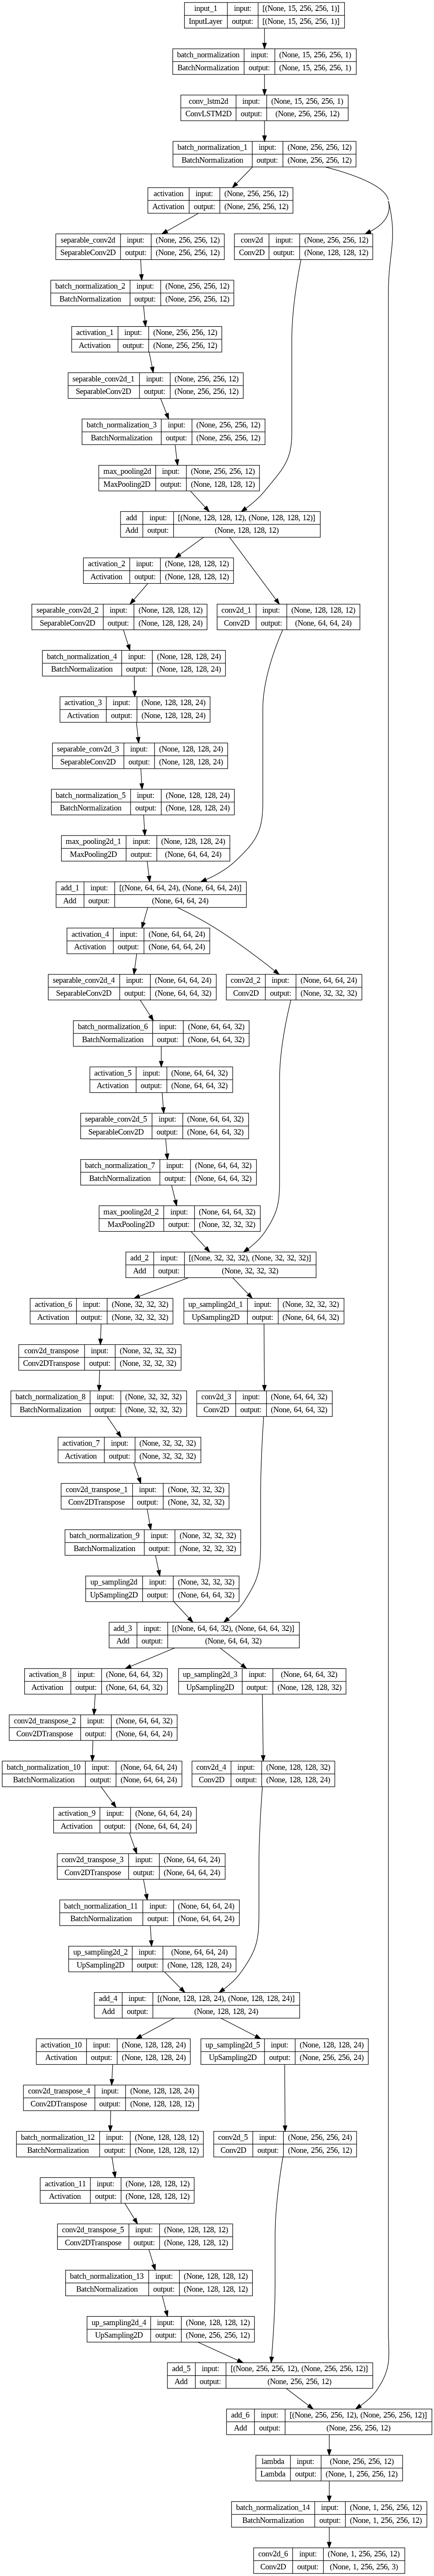

In [10]:
inputShape=train_set[0][0][0].shape
model= modelo_01(inputShape)
print(model.name)
plot_model(model, show_shapes=True, show_layer_names=True)

In [11]:
model.summary()

Model: "modelo_01"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15, 256, 25  0           []                               
                                6, 1)]                                                            
                                                                                                  
 batch_normalization (BatchNorm  (None, 15, 256, 256  4          ['input_1[0][0]']                
 alization)                     , 1)                                                              
                                                                                                  
 conv_lstm2d (ConvLSTM2D)       (None, 256, 256, 12  50592       ['batch_normalization[0][0]']    
                                )                                                         

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss=tf.keras.losses.SparseCategoricalCrossentropy(ignore_class = [2])
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'],
              weighted_metrics=['accuracy']
              )
earlystopping = tf.keras.callbacks.EarlyStopping(monitor= "val_weighted_accuracy", min_delta=0.0001,
                                                 patience=10, restore_best_weights=True,
                                                 verbose = 1)
start = pd.Timestamp.now()
history=model.fit(train_set, validation_data=val_set, epochs=100, batch_size=batch_size,
                  callbacks = [earlystopping])
end = pd.Timestamp.now()
model.save("/content/drive/My Drive/projeto_DL/"+model.name+".h5")

Epoch 1/100
60/60 [==============================] - 117s 2s/step - loss: 2.7466e-04 - accuracy: 0.1111 - weighted_accuracy: 0.0529 - val_loss: 7.6482e-04 - val_accuracy: 0.3091 - val_weighted_accuracy: 0.3530
Epoch 2/100
60/60 [==============================] - 98s 2s/step - loss: 2.7539e-04 - accuracy: 0.1985 - weighted_accuracy: 0.0963 - val_loss: 5.4962e-04 - val_accuracy: 0.1527 - val_weighted_accuracy: 0.1736
Epoch 3/100
60/60 [==============================] - 98s 2s/step - loss: 2.5623e-04 - accuracy: 0.2359 - weighted_accuracy: 0.1113 - val_loss: 5.9462e-04 - val_accuracy: 0.1764 - val_weighted_accuracy: 0.2173
Epoch 4/100
60/60 [==============================] - 98s 2s/step - loss: 2.5466e-04 - accuracy: 0.2001 - weighted_accuracy: 0.0877 - val_loss: 5.5339e-04 - val_accuracy: 0.0595 - val_weighted_accuracy: 0.0719
Epoch 5/100
60/60 [==============================] - 98s 2s/step - loss: 2.4537e-04 - accuracy: 0.2440 - weighted_accuracy: 0.1176 - val_loss: 6.8215e-04 - val_acc